In [1]:
import json
import argparse
import os
import json
from collections import defaultdict
from pyexpat import features
from re import S
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from scipy.stats import shapiro
import nltk
from nltk.tokenize import word_tokenize
import random
import textwrap
from radon.visitors import ComplexityVisitor

random.seed(42)


class BugData:
    def __init__(
        self,
        bug_id,
        bitvector,
        bitvector_dict,
        responses,
        available_bv,
        full_bv,
        full_available_bv,
        success_count,
        easy,
        facts,
    ):
        self.bug_id = bug_id
        self.bitvector = bitvector
        self.bitvector_dict = bitvector_dict
        repo = self.bug_id.split(":")[0]
        self.repo = repo
        if repo not in id_gen:
            global counter
            id_gen[repo] = counter
            counter += 1
        self.id = id_gen[repo]
        self.available_bv = available_bv
        self.easy = 1 if easy else 0
        error_dict = {
            "TypeError": 1,
            "ValueError": 2,
            "AttributeError": 3,
            "InvalidInput": 4,
        }
        self.full_bv = full_bv
        self.full_available_bv = full_available_bv
        self.error_type = 0
        self.issue_description_type = 0
        for key in error_dict:
            if key in bitvector_dict["4"]:
                self.error_type = error_dict[key]
            if key in bitvector_dict["6"]:
                self.issue_description_type = error_dict[key]
        if "```text" in self.bitvector_dict["6"]:
            self.has_code = 1
        else:
            self.has_code = 0
        self.facts = facts
        self.responses = responses
        self.success_count = success_count
        self.success_probability = None
        self.cyclomatic_complexity = self.compute_cyclomatic_complexity(facts["1.1.1"])
        self.prompt_length = self.compute_prompt_length()
        self.feature_vector = self.generate_feature_vector()

    def compute_cyclomatic_complexity(self, code: str):
        # Use radon to compute the cyclomatic complexity
        code = textwrap.dedent(code)
        try:
            visitor = ComplexityVisitor.from_code(code)
            # The total complexity is the sum of complexities of all blocks
            total_complexity = sum(block.complexity for block in visitor.blocks)
            return total_complexity
        except Exception as e:
            print(f"Error computing cyclomatic complexity: {e}")
            return 0

    def tokenize_and_count_nltk(self, text):
        tokens = word_tokenize(text)
        return len(tokens)

    def compute_prompt_length(self):
        su = 0
        for i, b in enumerate(self.available_bv, 1):
            if int(b) == 1:
                su += len(self.bitvector_dict[str(i)])
        return su

    def generate_feature_vector(self):
        feature = []
        feature = [int(bit) for bit in self.bitvector]
        nv = []
        feature.append(self.cyclomatic_complexity)
        for b in self.available_bv:
            nv.append(int(b))
        feature += nv
        feature += [self.prompt_length]
        xxx[(self.cyclomatic_complexity, self.success)] = (
            xxx.get((self.cyclomatic_complexity, self.success), 0) + 1
        )
        # feature += [int(bit) for bit in self.full_bv]

        # for b1, b2 in zip(self.full_bv, self.full_available_bv):
        #    if int(b2) == 1:
        #        feature.append(1)Do you want to restart the kernel of Stats.ipynb? All variables will be lost.

        #    else:
        #        feature.append(0)

        feature.append(int(self.error_type))
        feature.append(int(self.issue_description_type))
        return feature

    @property
    def success(self):
        return self.responses[0] == 0


/tmp/ipykernel_2575978/218558452.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def top_bitvectors(bug_data_list):
    success_count = defaultdict(int)
    total = defaultdict(int)
    bug_done = set()
    for bug_data in bug_data_list:
        if bug_data.success:
            success_count[bug_data.bitvector] += 1
    for key, value in success_count.items():
        success_count[key] = success_count[key]
    # Sort by success count in descending order
    sorted_bitvectors = sorted(success_count.items(), key=lambda x: x[1], reverse=True)
    top_bitvectors_union(bug_data_list)
    # Get top 5
    return sorted_bitvectors[:30]


def top_bitvectors_union(bug_data_list):
    success_count = defaultdict(int)
    bitvector_to_bug_ids = defaultdict(set)

    for bug_data in bug_data_list:
        if bug_data.success:
            success_count[bug_data.bitvector] += 1
            bitvector_to_bug_ids[bug_data.bitvector].add(bug_data.bug_id)
    print(success_count)
    sorted_bitvectors = sorted(success_count.items(), key=lambda x: x[1], reverse=True)

    top_5_bitvectors = sorted_bitvectors[:5]

    union_of_top_bitvectors = set()
    for bitvector, _ in top_5_bitvectors:
        union_of_top_bitvectors.update(bitvector_to_bug_ids[bitvector])
    print(len(union_of_top_bitvectors))


def load_facts_in_prompt(bug_dir):
    facts_file = os.path.join(bug_dir, "facts-in-prompt.json")
    if os.path.exists(facts_file):
        with open(facts_file, "r") as file:
            return json.load(file)
    else:
        print(f"facts-in-prompt.json not found in {bug_dir}.")
        return {}


def load_data_from_excel(excel_path):
    df = pd.read_excel(excel_path)
    return df


def create_bug_data_objects(df, facts_location):
    all_data = []
    for _, row in df.iterrows():
        repo = row["Project"]
        bug_id = row["Bug_id"]
        response = row["Pass Test"]
        actual_bv = row["result_filename"].split("_")[0].strip()
        exist_bv = "".join(
            [str(row[i]) for i in range(2, 9)]
        )  # Columns 3 to 9 for bitvector        # Convert 17-bit to 7-bit bitvector
        bitvector = convert_bitvector(actual_bv)

        bug_path = os.path.join(facts_location, repo, str(bug_id))
        bitvector_dict = load_facts_in_prompt(bug_path)
        all_data.append(
            BugData(f"{repo}:{bug_id}", bitvector, bitvector_dict, response, exist_bv)
        )
    return all_data


def convert_bitvector(actual_bv):
    # Define the groupings
    groupings = [(0, 1), (2, 4), (5, 6), (7, 10), (11, 14), (15, 16), (17, 17)]
    new_bv = ""

    for start, end in groupings:
        if any(actual_bv[i] == "1" for i in range(start, end + 1)):
            new_bv += "1"
        else:
            new_bv += "0"

    return new_bv


def calculate_success_rate(bug_data_list):
    bit_sum_success = defaultdict(lambda: {"success": 0, "total": 0, "lis": set()})
    for bug_data in bug_data_list:
        bit_sum = sum(map(int, bug_data.bitvector))
        bit_sum_success[bit_sum]["total"] += 1
        if bug_data.success:
            bit_sum_success[bit_sum]["lis"].add(bug_data.bug_id)
            bit_sum_success[bit_sum]["success"] += 1
    success_rates = {}
    for bit_sum, counts in bit_sum_success.items():
        success_rates[bit_sum] = (
            counts["success"] / counts["total"] if counts["total"] > 0 else 0
        )
    top_5_bit_sums = sorted(success_rates, key=success_rates.get, reverse=True)

    return top_5_bit_sums


def plot_success_rate(success_rate):
    # Sorting the keys for a better plot
    sorted_bit_sums = sorted(success_rate.keys())
    success_rates = [success_rate[bit_sum] for bit_sum in sorted_bit_sums]

    plt.plot(sorted_bit_sums, success_rates, marker="o")
    plt.xlabel("Sum of Bits")
    plt.ylabel("Success Rate")
    plt.title("Success Rate vs Sum of Bits")
    plt.grid(True)
    plt.show()


def find_bugs_without_bitvector(all_data, target_bitvector):
    bugs_without_target = set()
    has_set = set()
    for bug_data in all_data:
        if bug_data.bitvector == target_bitvector:
            has_set.add(bug_data.bug_id)
    for bug_data in all_data:
        if bug_data.bug_id not in has_set:
            bugs_without_target.add(bug_data.bug_id)
    return bugs_without_target


def remove_duplicates(bug_data_list):
    unique = []
    for item in bug_data_list:
        if all(not item.__eq__(existing) for existing in unique):
            unique.append(item)
    return unique


def calculate_optimal_success_rate(bug_data_list):
    # Group BugData by Bug ID
    bugs = defaultdict(list)
    for data in bug_data_list:
        bugs[data.bug_id].append(data)

    # Count bugs with at least one successful bitvector
    successful_bugs = 0
    for bug_id, bug_data in bugs.items():
        if any(data.success for data in bug_data):
            successful_bugs += 1

    # Calculate success rate
    total_unique_bugs = len(bugs)
    success_rate = successful_bugs / total_unique_bugs if total_unique_bugs > 0 else 0
    return successful_bugs, total_unique_bugs


def estimate_score_normal(model, test_data):
    test_groups = {}
    for bug in test_data:
        if bug.bug_id not in test_groups:
            test_groups[bug.bug_id] = []
        test_groups[bug.bug_id].append(bug)

    successful_selections = 0
    optimal_success_count = 0

    successful_selections = 0
    optimal_success_count = 0
    best_bitvectors = {}  # To store the best bitvector for each bug_id

    threshold = 0  # Set a threshold for the highest probability score
    top_k = 5  # Consider top 5 predictions

    for bug_id, bugs in test_groups.items():
        # Get probabilities for each bug
        bug_probabilities = [
            (bug, model.predict_proba([bug.feature_vector])[0][1]) for bug in bugs
        ]

        # Sort bugs by their probability in descending order
        sorted_bugs = sorted(bug_probabilities, key=lambda x: x[1], reverse=True)
        best_bug = sorted_bugs[0][0]

        best_bitvectors[bug_id] = best_bug.bitvector  # Store the best bitvector
        if best_bug.success:
            successful_selections += 1

        # Check for optimal success in the group
        if any(bug.success for bug in bugs):
            optimal_success_count += 1
    # Calculate accuracy and optimal accuracy
    accuracy = successful_selections / len(test_groups)
    optimal_accuracy = optimal_success_count / len(test_groups)

    # Print the results
    print(
        f"Model Accuracy: {accuracy}, Optimal Accuracy: {optimal_accuracy}, Successful"
        f" Selections: {successful_selections}, Total Groups: {len(test_groups)}"
    )

    # Process each group in test_groups
    bitvector_success_rates = {}
    for bug_id, bugs in test_groups.items():
        bv_set = set()
        for bug in bugs:
            bv_set.add(bug.bitvector)
            if bug.bitvector not in bitvector_success_rates:
                bitvector_success_rates[bug.bitvector] = {"successes": 0, "total": 0}

            bitvector_success_rates[bug.bitvector]["total"] += 1
            if bug.success:
                bitvector_success_rates[bug.bitvector]["successes"] += 1

    # Calculate success rate for each bitvector
    for bitvector, stats in bitvector_success_rates.items():
        success_rate = stats["successes"] / stats["total"]
        bitvector_success_rates[bitvector]["success_rate"] = success_rate
    print(f"Best bitvector (1001011): {bitvector_success_rates['1001011']}")
    # Find the bitvectors with the highest success rates
    highest_success_rate = max(
        rate["success_rate"] for rate in bitvector_success_rates.values()
    )
    best_bitvectors = [
        (bitvector, rate)
        for bitvector, rate in bitvector_success_rates.items()
        if rate["success_rate"] == highest_success_rate
    ]

    # Print the best bitvectors
    print(f"Bitvectors with the highest success rate: {best_bitvectors}")


def estimate_score_models(models, test_data):
    # Group test_data by bug_id
    test_groups = {}
    for bug in test_data:
        if bug.bug_id not in test_groups:
            test_groups[bug.bug_id] = []
        test_groups[bug.bug_id].append(bug)

    successful_selections = 0
    optimal_success_count = 0
    best_bitvectors = {}  # To store the best bitvector for each bug_id

    threshold = 0  # Set a threshold for the highest probability score
    top_k = 5  # Consider top 5 predictions

    for bug_id, bugs in test_groups.items():
        bug_probabilities = []

        for bug in bugs:
            model_index = int(
                bug.bitvector[1:], 2
            )  # Determine which model to use based on bitvector
            selected_model = models[model_index]
            probability = selected_model.predict_proba([bug.feature_vector])[0][1]
            bug_probabilities.append((bug, probability))

        # Sort bugs by their probability in descending order
        sorted_bugs = sorted(bug_probabilities, key=lambda x: x[1], reverse=True)

        # Select best bug based on threshold and randomness
        if sorted_bugs[0][1] >= threshold:
            best_bug = sorted_bugs[0][0]
        else:
            best_bug = random.choice(sorted_bugs[:top_k])[0]

        best_bitvectors[bug_id] = best_bug.bitvector  # Store the best bitvector
        if best_bug.success:
            successful_selections += 1

        # Check for optimal success in the group
        if any(bug.success for bug in bugs):
            optimal_success_count += 1

    # Calculate accuracy and optimal accuracy
    accuracy = successful_selections / len(test_groups) if test_groups else 0
    optimal_accuracy = optimal_success_count / len(test_groups) if test_groups else 0

    # Print the results
    print(
        f"Model Accuracy: {accuracy}, Optimal Accuracy: {optimal_accuracy}, Successful"
        f" Selections: {successful_selections}, Total Groups: {len(test_groups)}"
    )
    # Process each group in test_groups
    bitvector_success_rates = {}
    for bug_id, bugs in test_groups.items():
        bv_set = set()
        for bug in bugs:
            bv_set.add(bug.bitvector)
            if bug.bitvector not in bitvector_success_rates:
                bitvector_success_rates[bug.bitvector] = {"successes": 0, "total": 0}

            bitvector_success_rates[bug.bitvector]["total"] += 1
            if bug.success:
                bitvector_success_rates[bug.bitvector]["successes"] += 1
        assert len(bv_set) == 64
        assert len(bugs) == 64

    # Calculate success rate for each bitvector
    for bitvector, stats in bitvector_success_rates.items():
        success_rate = stats["successes"] / stats["total"]
        bitvector_success_rates[bitvector]["success_rate"] = success_rate
    print(f"Best bitvector (1001011): {bitvector_success_rates['1001011']}")
    # Find the bitvectors with the highest success rates
    highest_success_rate = max(
        rate["success_rate"] for rate in bitvector_success_rates.values()
    )
    best_bitvectors = [
        (bitvector, rate)
        for bitvector, rate in bitvector_success_rates.items()
        if rate["success_rate"] == highest_success_rate
    ]

    # Print the best bitvectors
    print(f"Bitvectors with the highest success rate: {best_bitvectors}")


def train_and_test_normal(all_data, include_list, model):
    include_set = set(include_list)
    # Create a unique set of bug IDs not in the include_list
    unique_bug_ids = set(
        bug.bug_id for bug in all_data if bug.bug_id not in include_set
    )
    include_set = set([bug.bug_id for bug in all_data if bug.bug_id in include_set])
    # Calculate the required size of the training set for a 50/50 split
    total_unique_ids = len(unique_bug_ids) + len(include_set)
    required_train_size = total_unique_ids // 2

    additional_ids_needed = required_train_size - len(include_set)

    # Split the remaining IDs to fill up the training set
    additional_train_ids, test_ids = train_test_split(
        sorted(list(unique_bug_ids)), train_size=additional_ids_needed, random_state=42
    )
    train_ids = set(list(include_set) + additional_train_ids)
    # Prepare the data splits
    train_data = [bug for bug in all_data if bug.bug_id in train_ids]
    test_data = [bug for bug in all_data if bug.bug_id in test_ids]
    # Assuming train_data is your original training dataset
    X_train = [bug.feature_vector for bug in train_data]
    y_train = [bug.success for bug in train_data]

    X_test = [bug.feature_vector for bug in test_data]
    y_test = [bug.success for bug in test_data]

    # Parameter tuning using GridSearchCV
    param_grid_rf = {
        "n_estimators": [100, 200, 300],  # Increased the upper limit for more averaging
        "max_depth": [5, 10, 15],  # Removed the deepest trees to prevent overfitting
        #"min_samples_split": [2, 5, 10],  # Uncommented to control the minimum size of a split
        #"min_samples_leaf": [1, 2, 4],  # Uncommented to control the minimum size of a leaf
        "max_features": ["sqrt", "log2", None],  # Added 'None' for using all features
        "bootstrap": [True],  # True is generally better for Random Forest to ensure diversity
        "criterion": ["gini", "entropy"],  # Both criteria are useful
        #"max_leaf_nodes": [None, 10, 20, 30],  # Added to limit the number of leaf nodes
        "oob_score": [True, False]  # Out-of-bag samples to estimate generalization accuracy
    }
    # Parameter grid for XGBoost
    param_grid_xgb = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 15, 20],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.5, 0.7, 1],
        "colsample_bytree": [0.5, 0.7, 1],
    }
    if model == "rf":
        model = RandomForestClassifier(random_state=42, class_weight="balanced")
        grid_search = GridSearchCV(model, param_grid_rf, cv=5, verbose=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)
    elif model == "xgb":
        model_xgb = XGBClassifier(
            random_state=42, use_label_encoder=False, eval_metric="logloss"
        )
        grid_search = GridSearchCV(
            model_xgb, param_grid_xgb, cv=5, verbose=3, n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

    # Use the best estimator to train the model
    best_model = grid_search.best_estimator_

    # Assuming 'model' is your trained RandomForestClassifier or RandomForestRegressor instance
    importances = best_model.feature_importances_

    # To make it easier to interpret, you can sort the features by importance
    indices = np.argsort(importances)[::-1]

    # Print the feature rankings
    print("Feature ranking:")

    for f in range(len(X_train[0])):  # Assuming X_train is your training feature set
        print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")

    estimate_score_normal(best_model, test_data)
    estimate_score_normal(best_model, train_data)
    estimate_score_normal(best_model, test_data + train_data)


def create_bug_data_objects_395(facts_location, easy=False):
    bug_data_objects = []
    print(facts_location)
    print(os.listdir(facts_location))
    # Iterate over repositories in the facts_location
    for repo in os.listdir(facts_location):
        repo_path = os.path.join(facts_location, repo)

        # Check if it's a directory
        if os.path.isdir(repo_path):
            # Iterate over bug_id directories in the repo
            for bug_id in os.listdir(repo_path):
                bug_id_path = os.path.join(repo_path, bug_id)

                # Read facts-in-prompt.json for bitvector_dict
                with open(
                    os.path.join(bug_id_path, "facts-in-prompt.json"), "r"
                ) as file:
                    bitvector_dict = json.load(file)

                # Iterate over files to find <bitvector>_result_1.json
                for filename in os.listdir(bug_id_path):
                    if filename.endswith("_result_1.json"):
                        # Extract bitvector from the filename
                        f_bitvector = filename.split("_")[0]

                        # Read the response from the result file
                        with open(
                            os.path.join(bug_id_path, filename), "r"
                        ) as result_file:
                            result_data = json.load(result_file)
                            response = result_data[
                                f"{repo}:{bug_id}"
                            ]  # Replace with actual key
                        with open(
                            os.path.join(
                                bug_id_path, filename.split("_")[0] + "_response_1.json"
                            )
                        ) as f:
                            response_data = json.load(f)
                            bitvector = convert_dict_to_bitvec(
                                response_data[repo][0]["strata"]
                            )
                            available_bv = convert_dict_to_bitvec(
                                response_data[repo][0]["available_strata"]
                            )
                            full_bv = convert_dict_to_bitvec(
                                response_data[repo][0]["bitvector"]
                            )
                            full_available_bv = convert_dict_to_bitvec(
                                response_data[repo][0]["available_bitvector"]
                            )
                        responses = []
                        success_count = 0
                        # Loop for handling response_i where i goes up to 10
                        for i in range(0, 11):
                            response_file = os.path.join(bug_id_path, f"{f_bitvector}_result_{i}.json")
                            if os.path.exists(response_file):
                                with open(response_file, "r") as result_file:
                                    result_data = json.load(result_file)
                                    response_i = result_data[f"{repo}:{bug_id}"]  # Replace with actual key
                                responses.append(response_i)
                                if response_i == 0:
                                    success_count += 1
                        # Calculate the overall response (assuming you want to multiply them as in your original code)
                        overall_response = 1
                        for response in responses:
                            overall_response *= response                        
                        facts_file = os.path.join(bug_id_path, "facts.json")
                        with open(facts_file) as f:
                            facts = json.load(f)

                        # Create a BugData object
                        bug_data = BugData(
                            f"{repo.lower()}:{bug_id}",
                            bitvector,
                            bitvector_dict,
                            responses,
                            available_bv,
                            full_bv,
                            full_available_bv,
                            success_count,
                            easy,
                            facts,
                        )                        
                        bug_data_objects.append(bug_data)

    return bug_data_objects


def convert_dict_to_bitvec(bitvec_dict):
    # Convert a dictionary to a bitvector string
    # Adjust this function based on how you want to represent the bitvector
    return "".join(str(bitvec_dict[key]) for key in sorted(bitvec_dict.keys()))


def analyze_bug_data(bug_data_list):
    # Initialize variables for analysis
    success_count = 0
    feature_sums = None
    feature_counts = defaultdict(int)

    # Iterate through each BugData instance
    for bug_data in bug_data_list:
        # Count successes
        if bug_data.success:
            success_count += 1
        numeric_feature_vector = [float(feature) for feature in bug_data.feature_vector]
        # Aggregate feature information
        if feature_sums is None:
            feature_sums = np.array(numeric_feature_vector)
        else:
            feature_sums += numeric_feature_vector

        for feature in numeric_feature_vector:
            feature_counts[feature] += 1

    # Calculate success rate
    total_count = len(bug_data_list)
    success_rate = success_count / total_count

    # Calculate average values for each feature
    avg_features = feature_sums / total_count

    # Sort features by occurrence
    sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)

    return {
        "success_rate": success_rate,
        "average_feature_values": avg_features,
        "most_common_feature": sorted_features[0],
        "least_common_feature": sorted_features[-1],
    }


def calculate_statistics(frequency_dict):
    success_counts = []
    failure_counts = []

    for (sum_val, success), count in frequency_dict.items():
        if success == 1:
            success_counts.extend([sum_val] * count)
        elif success == 0:
            failure_counts.extend([sum_val] * count)

    # Calculate statistics for success
    success_mean = np.mean(success_counts) if success_counts else 0
    success_median = np.median(success_counts) if success_counts else 0
    success_variance = np.var(success_counts) if success_counts else 0

    # Calculate statistics for failure
    failure_mean = np.mean(failure_counts) if failure_counts else 0
    failure_median = np.median(failure_counts) if failure_counts else 0
    failure_variance = np.var(failure_counts) if failure_counts else 0

    return {
        "success": {
            "mean": success_mean,
            "median": success_median,
            "variance": success_variance,
        },
        "failure": {
            "mean": failure_mean,
            "median": failure_median,
            "variance": failure_variance,
        },
    }


def compute_and_plot_success_rate(bug_data_list):
    # Dictionary to store success count and total count per partition
    partition_data = {}

    for bug_data in bug_data_list:
        # Determine the partition for this bug_data
        if bug_data.prompt_length > 40000:
            partition = "40000+"
        else:
            partition = (bug_data.prompt_length // 1000) * 1000

        # Initialize partition data if not already present
        if partition not in partition_data:
            partition_data[partition] = {"success_count": 0, "total_count": 0}

        # Update success count and total count
        partition_data[partition]["success_count"] += bug_data.success
        partition_data[partition]["total_count"] += 1
    # Calculate average success rate per partition
    average_success_rate = {
        partition: data["success_count"] / data["total_count"]
        for partition, data in partition_data.items()
    }
    print(
        partition_data[20000],
        partition_data[21000],
        partition_data[22000],
        partition_data[23000],
    )
    # Prepare data for plotting
    # Sort partitions with a custom key: integers as-is, '10000+' as a large number
    partitions = sorted(
        average_success_rate.keys(), key=lambda x: x if isinstance(x, int) else 10001
    )
    success_rates = [average_success_rate[partition] for partition in partitions]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(partitions)), success_rates, align="center")
    plt.xlabel("Prompt Length Partition")
    plt.ylabel("Average Success Rate")
    plt.title("Average Success Rate per Prompt Length Partition")
    # Label only every nth partition to avoid clutter
    n = 5  # Adjust n as needed for readability
    x_ticks_labels = [f"{p}" if isinstance(p, int) else p for p in partitions]
    x_ticks_positions = range(len(partitions))
    plt.xticks(
        x_ticks_positions[::n], x_ticks_labels[::n]
    )  # Adjust tick labels for readability

    plt.show()

def duplicate_data(all_data):
    repos = set(data.bug_id for data in all_data)
    for repo in repos:
        # Isolate data for the current repository
        repo_data = [data for data in all_data if data.bug_id == repo]
    
        # Initialize a dictionary to track bit positions
        bit_positions = {i: {'0', '1'} for i in range(7)}
        
        # Iterate over all bitvectors and record the status of each bit
        for data in repo_data:
            for i, bit in enumerate(data.bitvector):
                if bit in bit_positions[i]:
                    bit_positions[i].remove(bit)
        
        # Identify missing set bits
        missing_set_bits = {pos for pos, states in bit_positions.items() if states and pos != 0}
        visited_bv = {data.bitvector for data in repo_data}
        added_data = 0
        # Create duplicates for missing set bits
        for data in repo_data:
            # Check if the data has missing bits unset
            if all(data.bitvector[missing_bit] == '0' for missing_bit in missing_set_bits):
                # Generate all combinations for the missing bits being set
                for combination in itertools.product(['0', '1'], repeat=len(missing_set_bits)):
                    new_bitvector = list(data.bitvector)
                    for bit_index, missing_bit in enumerate(missing_set_bits):
                        new_bitvector[missing_bit] = combination[bit_index]
                    new_bitvector = ''.join(new_bitvector)
                    if new_bitvector in visited_bv:
                        continue
                    # Create a duplicate BugData object with the new bitvector
                    added_data += 1
                    duplicate_data = deepcopy(data)
                    duplicate_data.bitvector = new_bitvector                
                    all_data.append(duplicate_data)


In [3]:
from copy import deepcopy
import itertools
import os
xxx = {}

id_gen = {}
counter = 1

facts_location = "../../LPPR-data/16-16-dataset-09-01-2024/16-215-dataset"
facts_location_395 = "../../LPPR-data/16-16-dataset-09-01-2024/16-100-dataset"

all_data_easy = create_bug_data_objects_395(facts_location, easy=True)
all_data_hard = create_bug_data_objects_395(facts_location_395)
all_data_easy += all_data_hard 
all_data_combined = all_data_easy
data_2 =  create_bug_data_objects_395("../../LPPR-data/16-16-dataset-16-01-24/")
# Get unique repositories
duplicate_data(all_data_combined)
duplicate_data(data_2)

../../LPPR-data/16-16-dataset-09-01-2024/16-215-dataset
['luigi', 'fastapi', 'pandas', 'keras', 'scrapy', 'thefuck']
../../LPPR-data/16-16-dataset-09-01-2024/16-100-dataset
['luigi', 'black', 'pandas', 'tornado', 'matplotlib', 'keras', 'scrapy']
../../LPPR-data/16-16-dataset-16-01-24/
['luigi', 'black', 'fastapi', 'pandas', 'tornado', 'matplotlib', 'README.md', 'keras', 'scrapy', 'results.txt', 'thefuck']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


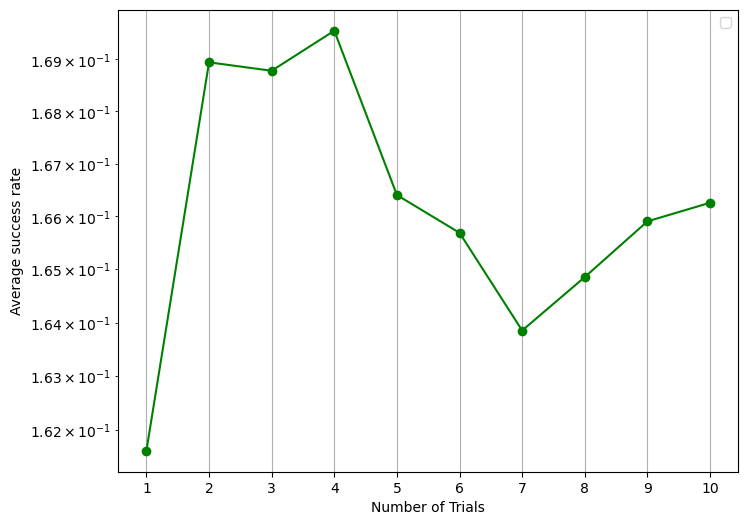

0.34375
0.40625
0.5
0.5625
0.375
0.46875
0.3125
0.4375
0.4375
0.375
0.3125
0.125
0.28125
0.3125
0.375
0.40625
0.25
0.46875
0.28125
0.25
0.375
0.4375
0.53125
0.25
0.15625
0.21875
0.5
0.40625
0.34375
0.375
0.5625
0.25
0.5625
0.3125
0.40625
0.53125
0.46875
0.59375
0.125
0.25
0.53125
0.28125
0.40625
0.3125
0.5
0.46875
0.25
0.5
0.28125
0.40625
0.46875
0.15625
0.25
0.21875
0.21875
0.1875
0.4375
0.25
0.25
0.4375
0.46875
0.53125
0.46875
0.40625


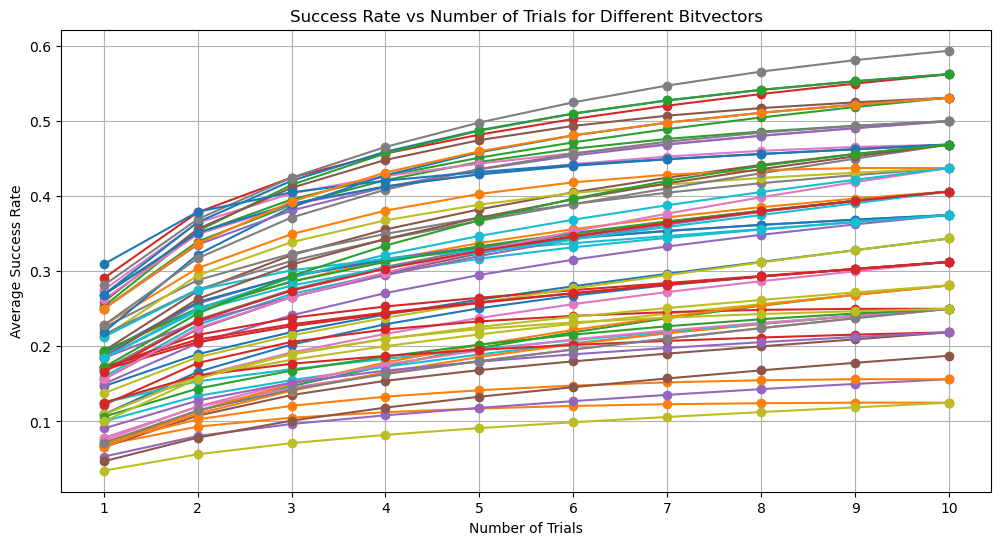

In [25]:

# Function to calculate success rate for a given number of trials
def calculate_success_rate(responses, trials):
    return responses[:trials].count(0) / trials

def pass_at_trials(responses, trials):
    """
    Calculate pass@trials using combinatorial method.

    :param responses: list of response outcomes (0 for success, non-zero for failure)
    :param trials: number of trials to consider (k in pass@k)
    :return: Probability of at least one success within the first 'trials' attempts.
    """
    n = len(responses)  # Total number of samples
    c = responses.count(0)  # Number of successes

    if n - c < trials: 
        return 1.0

    # Calculate probability of no success in the first 'trials' attempts and subtract from 1
    return 1.0 - np.prod(1.0 - trials / np.arange(n - c + 1, n + 1))

max_trials = 10

# Prepare data for plotting
trial_range = range(1, max_trials + 1)
all_data_combined = [data for data in all_data_combined]
# Initialize dictionaries to store success rates for each trial count
success_rates_combined = {trial: [] for trial in trial_range}


for bug_data in all_data_combined:
    for trial in trial_range:
        rate = calculate_success_rate(bug_data.responses, trial)
        success_rates_combined[trial].append(rate)


# Calculate average success rates for each trial count for both simple and hard data
average_success_rates_combined = [np.mean(success_rates_combined[trial]) for trial in trial_range]

# Plotting success rate vs number of trials for simple and hard data in the same plot
plt.figure(figsize=(8, 6))

plt.plot(trial_range, average_success_rates_combined, marker='o', color='green')
plt.yscale('log')
plt.xlabel('Number of Trials')
plt.ylabel('Average success rate')
plt.xticks(trial_range)
plt.grid(True)
plt.legend()
plt.savefig("success.svg")
plt.show()


# Specific bitvectors to plot
all_bitvectors = ["1" + format(i, '06b') for i in range(2**6)]

# Adding the provided bitvectors to the generated list
# Using a set to avoid duplicates
all_bitvectors_set = set(all_bitvectors)

# Converting the set back to a list
complete_bitvectors = list(all_bitvectors_set)
bitvectors_to_plot = complete_bitvectors
success_rates = {bv: {trial: [] for trial in trial_range} for bv in bitvectors_to_plot}
# Filter data and calculate success rates for each bitvector
for bv in bitvectors_to_plot:
    data_bv = [data for data in all_data_combined if data.bitvector == bv]
    for trial in trial_range:
        for data in data_bv:
            rate = pass_at_trials(data.responses, trial)
            success_rates[bv][trial].append(rate)

# Plotting
plt.figure(figsize=(12, 6))
for bv in bitvectors_to_plot:
    average_success_rates = [np.mean(success_rates[bv][trial]) for trial in trial_range]
    print(np.mean(success_rates[bv][trial]))
    plt.plot(trial_range, average_success_rates, marker='o', label=f'Bitvector: {bv}')

plt.xlabel('Number of Trials')
plt.ylabel('Average Success Rate')
plt.title('Success Rate vs Number of Trials for Different Bitvectors')
plt.xticks(trial_range)
plt.grid(True)
plt.show()




In [5]:
def compare_pass_at_k_for_bitvectors(bv1, bv2, all_data_combined, k):
    """
    Compare pass@k for two bitvectors across all bugs.
    :param bv1: First bitvector
    :param bv2: Second bitvector
    :param all_data_combined: List of all data
    :param k: The 'k' in pass@k
    :return: Dictionary with pass@k comparison for each bug
    """
    # Filter data for each bitvector
    data_bv1 = [data for data in all_data_combined if data.bitvector == bv1]
    data_bv2 = [data for data in all_data_combined if data.bitvector == bv2]

    # Compare pass@k for each bug
    comparison_results = {}
    for bug_id in set(data.bug_id for data in all_data_combined):
        responses_bv1 = [data.responses for data in data_bv1 if data.bug_id == bug_id]
        responses_bv2 = [data.responses for data in data_bv2 if data.bug_id == bug_id]

        if responses_bv1 and responses_bv2:
            pass_k_bv1 = np.mean([pass_at_trials(responses, k) for responses in responses_bv1])
            pass_k_bv2 = np.mean([pass_at_trials(responses, k) for responses in responses_bv2])
            comparison_results[bug_id] = (pass_k_bv1, pass_k_bv2)

    return comparison_results

a = 0
comparision_results = compare_pass_at_k_for_bitvectors("1001011", "1001001", all_data_combined, 10)
for key, c in comparision_results.items():
    if abs(c[0]-c[1]) > 0.3:
        print(c)
        a += 1
print(len(comparision_results), a)

(0.0, 1.0)
(1.0, 0.0)
(1.0, 0.0)
32 3


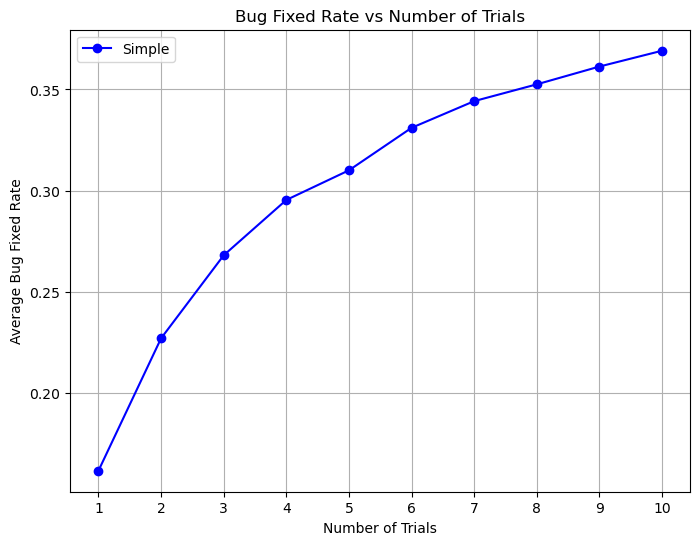

In [6]:
# Function to calculate if a bug is fixed within a given number of trials
def is_bug_fixed(responses, trials):
    return 1 if 0 in responses[:trials] else 0

# Set the maximum number of trials to consider (assuming a maximum of 10)
max_trials = 10

# Prepare data for plotting
trial_range = range(1, max_trials + 1)

# Initialize dictionaries to store 'bug fixed' flags for each trial count
fixed_flags_simple = {trial: [] for trial in trial_range}
fixed_flags_hard = {trial: [] for trial in trial_range}

# Calculate 'bug fixed' flags for each number of trials in all_data_simple
for bug_data in all_data_easy:
    for trial in trial_range:
        flag = is_bug_fixed(bug_data.responses, trial)
        fixed_flags_simple[trial].append(flag)

# Calculate 'bug fixed' flags for each number of trials in all_data_hard
#for bug_data in all_data_hard:
#    for trial in trial_range:
#        flag = is_bug_fixed(bug_data.responses, trial)
#        fixed_flags_hard[trial].append(flag)

# Calculate average 'bug fixed' rate for each trial count for both simple and hard data
average_fixed_rate_simple = [np.mean(fixed_flags_simple[trial]) for trial in trial_range]
#average_fixed_rate_hard = [np.mean(fixed_flags_hard[trial]) for trial in trial_range]

# Plotting 'bug fixed' rate vs number of trials for simple and hard data in the same plot
plt.figure(figsize=(8, 6))

plt.plot(trial_range, average_fixed_rate_simple, marker='o', color='blue', label='Simple')
#plt.plot(trial_range, average_fixed_rate_hard, marker='o', color='red', label='Hard')

plt.xlabel('Number of Trials')
plt.ylabel('Average Bug Fixed Rate')
plt.title('Bug Fixed Rate vs Number of Trials')
plt.xticks(trial_range)This logarithmic-scale plot illustrates the relationship between pass@k and the number of trials (k) for 10 responses. Initially, there is a marked increase in pass@k, which is particularly pronounced up to k=3. Beyond this point, the rate of improvement diminishes, indicating a diminishing return on additional trials
plt.grid(True)
plt.legend()

plt.show()


In [7]:
from collections import Counter
import pandas as pd

index_mapping = {
    1: 'class data',
    2: 'file data',
    3: 'test data',
    4: 'dynamic variable data',
    5: 'Github data',
    6: 'CoT data'
}
# Redefining the feature counters
feature_counters = {feature: {0: 0, 1: 0} for feature in index_mapping.values()}

# Function to check for success within the first 3 trials
def is_success_within_first_k_trials(responses, k):
    return 1 if 0 in responses[:k] else 0

# Counting successes and failures based on the new success definition
for bug_data in all_data_combined:
    bitvector = bug_data.bitvector
    success = is_success_within_first_k_trials(bug_data.responses, 10)
    for index, feature in index_mapping.items():
        feature_value = int(bitvector[index])
        if feature_value == 1:
            feature_counters[feature][success] += bug_data.responses[0] == 0

# Creating a contingency matrix from the counters
contingency_matrix = pd.DataFrame.from_dict(feature_counters, orient='index', columns=[0, 1])
# Adding a 'difference' column (success count - failure count)
contingency_matrix['difference'] = contingency_matrix[1] - contingency_matrix[0]
contingency_matrix = contingency_matrix.sort_values(by='difference', ascending=False)
contingency_matrix




,0,1,difference
test data,0,228,228
Github data,0,194,194
CoT data,0,194,194
class data,0,163,163
dynamic variable data,0,158,158
file data,0,149,149


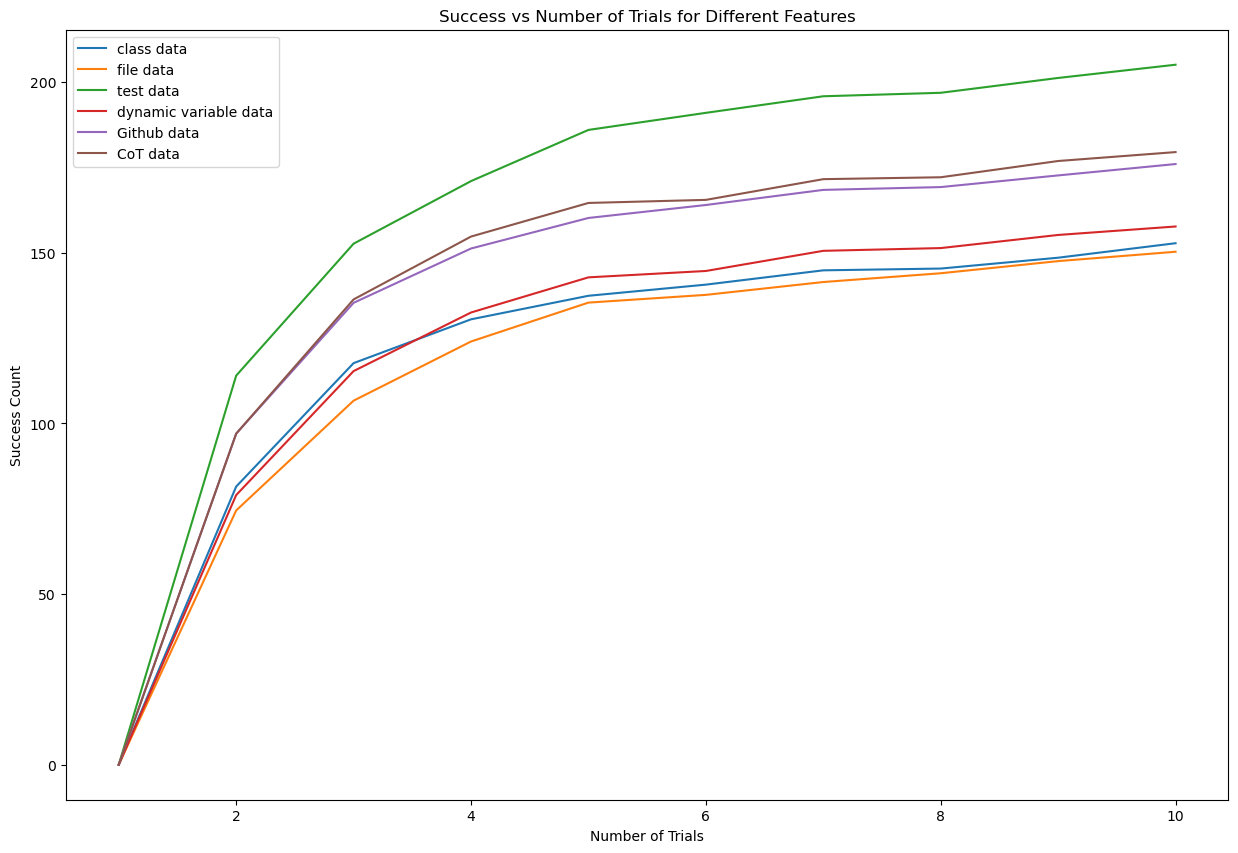

In [8]:

# Redefining the feature counters for each trial
feature_counters = {feature: [0] * 10 for feature in index_mapping.values()}

# Updating the counting logic
for bug_data in all_data_combined:
    bitvector = bug_data.bitvector
    for index, feature in index_mapping.items():
        feature_value = int(bitvector[index])
        if feature_value == 1:
            for trial in range(10):
                if 0 in bug_data.responses[:trial]:
                    feature_counters[feature][trial] += bug_data.responses[:trial].count(0)/(1 + trial)

# Plotting success vs number of trials for different features
plt.figure(figsize=(15, 10))

for feature, counts in feature_counters.items():
    plt.plot(range(1, 11), counts, label=feature)

plt.xlabel('Number of Trials')
plt.ylabel('Success Count')
plt.title('Success vs Number of Trials for Different Features')
plt.legend()
plt.show()

In [9]:
top_bitvectors(all_data_easy)

defaultdict(<class 'int'>, {'1101101': 10, '1001101': 6, '1010001': 1, '1100000': 2, '1111001': 7, '1101001': 9, '1111100': 2, '1001100': 8, '1011000': 3, '1101000': 7, '1111101': 7, '1001001': 9, '1101100': 7, '1001000': 6, '1011001': 9, '1011101': 8, '1000000': 2, '1010000': 3, '1111000': 4, '1110001': 2, '1110101': 3, '1100101': 3, '1010111': 6, '1011011': 9, '1000111': 5, '1111011': 8, '1001010': 7, '1100011': 5, '1100001': 3, '1110010': 5, '1001110': 8, '1010110': 4, '1000001': 3, '1001011': 11, '1011110': 6, '1101010': 8, '1001111': 7, '1011010': 7, '1000110': 4, '1000010': 4, '1011111': 9, '1010010': 3, '1000011': 4, '1010011': 6, '1010101': 3, '1011100': 3, '1010100': 1, '1111111': 6, '1101110': 6, '1110111': 5, '1100010': 5, '1101011': 11, '1110011': 4, '1100111': 5, '1101111': 9, '1111110': 6, '1110110': 2, '1100110': 4, '1111010': 5, '1000100': 2, '1110100': 1, '1110000': 1, '1100100': 1, '1000101': 1})
14


[('1001011', 11),
 ('1101011', 11),
 ('1101101', 10),
 ('1101001', 9),
 ('1001001', 9),
 ('1011001', 9),
 ('1011011', 9),
 ('1011111', 9),
 ('1101111', 9),
 ('1001100', 8),
 ('1011101', 8),
 ('1111011', 8),
 ('1001110', 8),
 ('1101010', 8),
 ('1111001', 7),
 ('1101000', 7),
 ('1111101', 7),
 ('1101100', 7),
 ('1001010', 7),
 ('1001111', 7),
 ('1011010', 7),
 ('1001101', 6),
 ('1001000', 6),
 ('1010111', 6),
 ('1011110', 6),
 ('1010011', 6),
 ('1111111', 6),
 ('1101110', 6),
 ('1111110', 6),
 ('1000111', 5)]

In [10]:
top_bitvectors_union(all_data_easy)

defaultdict(<class 'int'>, {'1101101': 10, '1001101': 6, '1010001': 1, '1100000': 2, '1111001': 7, '1101001': 9, '1111100': 2, '1001100': 8, '1011000': 3, '1101000': 7, '1111101': 7, '1001001': 9, '1101100': 7, '1001000': 6, '1011001': 9, '1011101': 8, '1000000': 2, '1010000': 3, '1111000': 4, '1110001': 2, '1110101': 3, '1100101': 3, '1010111': 6, '1011011': 9, '1000111': 5, '1111011': 8, '1001010': 7, '1100011': 5, '1100001': 3, '1110010': 5, '1001110': 8, '1010110': 4, '1000001': 3, '1001011': 11, '1011110': 6, '1101010': 8, '1001111': 7, '1011010': 7, '1000110': 4, '1000010': 4, '1011111': 9, '1010010': 3, '1000011': 4, '1010011': 6, '1010101': 3, '1011100': 3, '1010100': 1, '1111111': 6, '1101110': 6, '1110111': 5, '1100010': 5, '1101011': 11, '1110011': 4, '1100111': 5, '1101111': 9, '1111110': 6, '1110110': 2, '1100110': 4, '1111010': 5, '1000100': 2, '1110100': 1, '1110000': 1, '1100100': 1, '1000101': 1})
14


In [11]:
calculate_optimal_success_rate(all_data_easy)

(18, 32)

In [12]:
top_bitvectors(data_2)

defaultdict(<class 'int'>, {'1011100': 7, '1101101': 7, '1001101': 9, '1100000': 1, '1111001': 9, '1101001': 8, '1111100': 4, '1001100': 7, '1011000': 5, '1101000': 4, '1111101': 10, '1001001': 12, '1101100': 4, '1001000': 5, '1011001': 11, '1110000': 3, '1000001': 2, '1011101': 10, '1000000': 2, '1111000': 5, '1111111': 8, '1011011': 13, '1001111': 9, '1000111': 5, '1011110': 5, '1001011': 12, '1111011': 13, '1110111': 5, '1001010': 7, '1011010': 7, '1010111': 6, '1101011': 12, '1000110': 2, '1110011': 5, '1100111': 6, '1000010': 4, '1101010': 6, '1101111': 10, '1111110': 6, '1011111': 9, '1100011': 6, '1010010': 2, '1001110': 7, '1010110': 3, '1000011': 6, '1110110': 3, '1010011': 4, '1000101': 5, '1110101': 5, '1100101': 5, '1100010': 5, '1010100': 1, '1000100': 3, '1010101': 3, '1100110': 2, '1110001': 2, '1111010': 4, '1100100': 2, '1110100': 2, '1100001': 1, '1110010': 4, '1101110': 4, '1010001': 1, '1010000': 1})
17


[('1011011', 13),
 ('1111011', 13),
 ('1001001', 12),
 ('1001011', 12),
 ('1101011', 12),
 ('1011001', 11),
 ('1111101', 10),
 ('1011101', 10),
 ('1101111', 10),
 ('1001101', 9),
 ('1111001', 9),
 ('1001111', 9),
 ('1011111', 9),
 ('1101001', 8),
 ('1111111', 8),
 ('1011100', 7),
 ('1101101', 7),
 ('1001100', 7),
 ('1001010', 7),
 ('1011010', 7),
 ('1001110', 7),
 ('1010111', 6),
 ('1100111', 6),
 ('1101010', 6),
 ('1111110', 6),
 ('1100011', 6),
 ('1000011', 6),
 ('1011000', 5),
 ('1001000', 5),
 ('1111000', 5)]

In [13]:
top_bitvectors_union(data_2)

defaultdict(<class 'int'>, {'1011100': 7, '1101101': 7, '1001101': 9, '1100000': 1, '1111001': 9, '1101001': 8, '1111100': 4, '1001100': 7, '1011000': 5, '1101000': 4, '1111101': 10, '1001001': 12, '1101100': 4, '1001000': 5, '1011001': 11, '1110000': 3, '1000001': 2, '1011101': 10, '1000000': 2, '1111000': 5, '1111111': 8, '1011011': 13, '1001111': 9, '1000111': 5, '1011110': 5, '1001011': 12, '1111011': 13, '1110111': 5, '1001010': 7, '1011010': 7, '1010111': 6, '1101011': 12, '1000110': 2, '1110011': 5, '1100111': 6, '1000010': 4, '1101010': 6, '1101111': 10, '1111110': 6, '1011111': 9, '1100011': 6, '1010010': 2, '1001110': 7, '1010110': 3, '1000011': 6, '1110110': 3, '1010011': 4, '1000101': 5, '1110101': 5, '1100101': 5, '1100010': 5, '1010100': 1, '1000100': 3, '1010101': 3, '1100110': 2, '1110001': 2, '1111010': 4, '1100100': 2, '1110100': 2, '1100001': 1, '1110010': 4, '1101110': 4, '1010001': 1, '1010000': 1})
17


In [14]:
calculate_optimal_success_rate(data_2)

(20, 32)

In [15]:

feature_counters = {feature: {0: 0, 1: 0} for feature in index_mapping.values()}

# Counting successes and failures based on the new success definition
for bug_data in data_2:
    bitvector = bug_data.bitvector
    success = is_success_within_first_k_trials(bug_data.responses, 1)
    for index, feature in index_mapping.items():
        feature_value = int(bitvector[index])
        if feature_value == 1:
            feature_counters[feature][success] += bug_data.responses.count(0)

print(feature_counters)
# Creating a contingency matrix from the counters
contingency_matrix2 = pd.DataFrame.from_dict(feature_counters, orient='index', columns=[0, 1])
# Adding a 'difference' column (success count - failure count)
contingency_matrix2['difference'] = contingency_matrix2[1] - contingency_matrix2[0]
contingency_matrix2 = contingency_matrix2.sort_values(by='difference', ascending=False)
contingency_matrix2




{'class data': {0: 0, 1: 171}, 'file data': {0: 0, 1: 176}, 'test data': {0: 0, 1: 249}, 'dynamic variable data': {0: 0, 1: 174}, 'Github data': {0: 0, 1: 200}, 'CoT data': {0: 0, 1: 229}}


,0,1,difference
test data,0,249,249
CoT data,0,229,229
Github data,0,200,200
file data,0,176,176
dynamic variable data,0,174,174
class data,0,171,171


In [16]:
contingency_matrix

,0,1,difference
test data,0,228,228
Github data,0,194,194
CoT data,0,194,194
class data,0,163,163
dynamic variable data,0,158,158
file data,0,149,149


In [17]:
len(all_data_easy)


2048

In [18]:
len(all_data_combined)

2048

In [19]:

# Assuming all_data_easy is your list of BugData objects
data = [bug_data.success_count for bug_data in all_data_easy if bug_data.success_count > 0]

# Create a DataFrame
df = pd.DataFrame(data, columns=['success_count'])


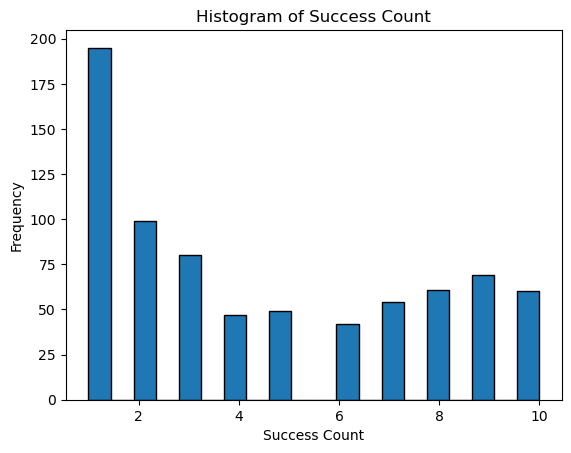

In [20]:
df['success_count'].plot(kind='hist', bins=20, edgecolor='black')
plt.title('Histogram of Success Count')
plt.xlabel('Success Count')
plt.ylabel('Frequency')
plt.show()

In [21]:
import scipy.stats as stats

# Let's say you have this number of successes and trials
number_of_successes = sum(bug_data.success_count for bug_data in all_data_easy)
total_trials = len(all_data_easy)*10

# Sample proportion of successes
p_hat = number_of_successes / total_trials

# Calculate the standard error
standard_error = (p_hat * (1 - p_hat) / total_trials) ** 0.5

# Compute z-score for a 95% confidence interval
z_score = stats.norm.ppf(0.975)  # Two-tailed z-score for 95%

# Calculate the margin of error
margin_of_error = z_score * standard_error

# Construct the confidence interval
confidence_interval = (p_hat - margin_of_error, p_hat + margin_of_error)

print(f"The 95% confidence interval for the probability of success is: {confidence_interval}")

The 95% confidence interval for the probability of success is: (0.161160682676194, 0.171358848573806)
